Friday, November 17, 2023

[Fine-tuning Mistral 7B on a Single GPU with Ludwig](https://predibase.com/blog/fine-tuning-mistral-7b-on-a-single-gpu-with-ludwig)

### **Install Ludwig and Ludwig's LLM related dependencies.**

In [ ]:
# !pip uninstall -y tensorflow --quiet
# !pip install --upgrade git+https://github.com/huggingface/transformers
# !pip install --upgrade git+https://github.com/huggingface/peft.git
# !pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-8fqc93o4
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-8fqc93o4
  Resolved https://github.com/huggingface/transformers to commit 43bfd093e1817c0333a1e10fcbdd54f1032baad0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/huggingface/peft.git to /tmp/pip-req-build-82yzmqcy
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/peft.git /tmp/pip-req-build-82yzmqcy
  Resolved https://github.com/huggingface/peft.git to commit 99f792e8a3be001c55e71d148a7a8d25b931181f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metada

In [ ]:
# !pip install --upgrade datasets

In [ ]:
# !pip install py7zr

In [ ]:
# !pip install xformers

In [ ]:
!pip show torch

Name: torch
Version: 2.0.1+cu118
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, jinja2, networkx, sympy, triton, typing-extensions
Required-by: accelerate, fastai, ludwig, peft, torchaudio, torchdata, torchmetrics, torchtext, torchvision, triton, xformers


In [ ]:
!pip show transformers

Name: transformers
Version: 4.35.0.dev0
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: ludwig, peft


In [ ]:

import os

import copy

import gc

from typing import Any, Callable

import time

from functools import wraps
from inspect import (
    BoundArguments,
    signature,
)

from collections import OrderedDict

from google.colab import data_table

import yaml

import numpy as np
import pandas as pd

import torch
from torch import Tensor

import datasets
from datasets import load_dataset, Dataset, DatasetDict

import transformers
from transformers import BitsAndBytesConfig, AutoModelForCausalLM, LlamaForCausalLM, MistralForCausalLM, AutoTokenizer, LlamaTokenizerFast, GenerationConfig, TextGenerationPipeline, BatchEncoding
from transformers.generation.utils import GreedySearchDecoderOnlyOutput

from peft import PeftModel, PeftModelForCausalLM, PeftConfig, LoraConfig

from ludwig.api import LudwigModel, TrainingResults


import logging

Enable text wrapping so we don't have to scroll horizontally and create a function to flush CUDA cache.

In [ ]:
from IPython.display import HTML, display

def set_css() -> None:
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))

get_ipython().events.register('pre_run_cell', set_css)


In [ ]:
def predict(model: LudwigModel, df_test: pd.DataFrame) -> list[list[str]]:
  return model.predict(df_test)[0]["summary_response"].tolist()

### **Setup Your HuggingFace Token** 🤗

Obtain a [HuggingFace API Token](https://huggingface.co/settings/tokens) before proceeding. You may need to signup on HuggingFace if you do not aleady have an account: https://huggingface.co/join


In [ ]:
import getpass
# import locale; locale.getpreferredencoding = lambda: "UTF-8"
import logging
import os
import torch
import yaml

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"

locale.getpreferredencoding = getpreferredencoding


os.environ["HUGGING_FACE_HUB_TOKEN"] = getpass.getpass("Token:")
assert os.environ["HUGGING_FACE_HUB_TOKEN"]

Token:··········


### **Import The SAMSum Dataset** 📋



In [ ]:
import datasets
from datasets import load_dataset, Dataset, DatasetDict

In [ ]:
samsum_dataset_dict: DatasetDict = datasets.load_dataset("samsum")
samsum_dataset_dict

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [ ]:
train_dataset: Dataset = samsum_dataset_dict["train"]
test_dataset: Dataset = samsum_dataset_dict["test"]
validation_dataset: Dataset = samsum_dataset_dict["validation"]

In [ ]:
df_train: pd.DataFrame = train_dataset.to_pandas()
df_test: pd.DataFrame = test_dataset.to_pandas()
df_validation: pd.DataFrame = validation_dataset.to_pandas()

In [ ]:
df_evaluation: pd.DataFrame = df_train.sample(n=10, random_state=200)
df_train = df_train.drop(df_evaluation.index)

In [ ]:
df_train = df_train.sample(n=700, random_state=200)
df_test = df_test.sample(n=200, random_state=200)
df_validation = df_validation.sample(n=100, random_state=200)

In [ ]:
assert df_train.shape[0] == 700
assert df_test.shape[0] == 200
assert df_validation.shape[0] == 100

In [ ]:
from google.colab import data_table; data_table.enable_dataframe_formatter()
import numpy as np; np.random.seed(123)

In [ ]:
df_train["split"] = np.zeros(df_train.shape[0])
df_test["split"] = np.ones(df_test.shape[0])
df_validation["split"] = np.full(df_validation.shape[0], 2)

In [ ]:
df_dataset = pd.concat([df_train, df_test, df_validation])

In [ ]:
df_dataset["split"] = df_dataset["split"].astype(int)

In [ ]:
df_dataset.shape

(1000, 4)

In [ ]:
assert df_dataset[df_dataset["split"] == 0].shape[0] == 700
assert df_dataset[df_dataset["split"] == 1].shape[0] == 200
assert df_dataset[df_dataset["split"] == 2].shape[0] == 100

In [ ]:
df_dataset.head(10)

,id,dialogue,summary,split
7270,13828796,"Adella: Hey!! So, for the longest time I've a ...",Rod and Adella will compose a song together. T...,0
1109,13863061,Tori: New hair!\nTori: <file_photo>\nHugh: Pre...,Hugh likes Tori's new haircut.,0
13165,13681152,"Martin: Hi Tom, this is my new mobile number i...",Martin and Tom are going to meet next year to ...,0
11264,13716583,Phoebe: I had a terrible day. Anyone up for so...,Phoebe had a terrible day. She will meet at 7:...,0
11662,13812757,Michael: I was in no mood for talk \r\nMichael...,They were gossiping about Michael. He will com...,0
592,13715945,Nick: Opinions required! Gas or induction hob?...,Nick decided to buy an induction hob.,0
1681,13815727,"Aubrey: how was your trip, babe? are you alrea...",Jackson is on a trip. His journey on the train...,0
3470,13611993,Scott: Wanna smthg from the shop?\r\nJenna: no...,Jenna asks Scott to buy her an adhesive bandag...,0
5690,13810506,"Jane: Hey gorgeous, have any plans for the sum...",Patricia and Jane will go on an organised trip...,0
2512,13729573,Regina: did you finish the required trainings ...,Tatiana hasn't finished the required trainings...,0


Average number of tokens in the dialogue column: 173
Average number of tokens in the summary column: 37


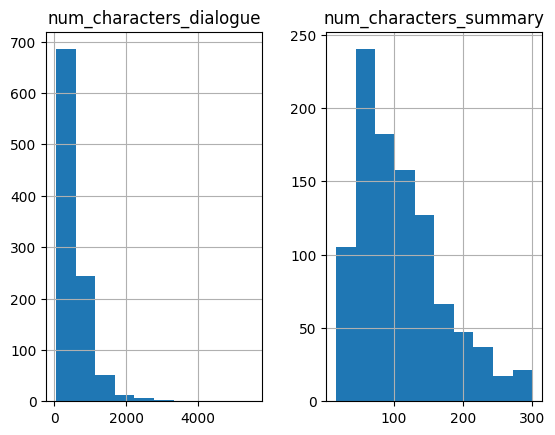

In [ ]:
# Calculating the length of each cell in each column
df_dataset['num_characters_dialogue'] = df_dataset['dialogue'].apply(lambda x: len(x))
df_dataset['num_characters_summary'] = df_dataset['summary'].apply(lambda x: len(x))

# Show Distribution
df_dataset.hist(column=['num_characters_dialogue', 'num_characters_summary'])

# Calculating the average
average_chars_dialogue= df_dataset['num_characters_dialogue'].mean()
average_chars_summary = df_dataset['num_characters_summary'].mean()

print(f'Average number of tokens in the dialogue column: {(average_chars_dialogue / 3):.0f}')
print(f'Average number of tokens in the summary column: {(average_chars_summary / 3):.0f}')


In [ ]:
df_evaluation

,id,dialogue,summary
2613,13817590,"Adriana: Sorry, I guess I can't make it. I'm f...","Adriana is feeling sick, so she needs to give ..."
1446,13820141-1,Claire: Have you seen the news?\r\nGreg: No. W...,Claire is unhappy about her neighbour becoming...
123,13863151,Josh: You're a nutter!!!\nJosh: I could never ...,Paul didn't convince Josh to go bungee jumping...
10820,13682324,Marcel: Hey\r\nRodolfo: Hello\r\nMarcel: What'...,"Rodolfo took a difficult exam today, he'll get..."
7557,13862729,Don: Do you see me online?\nAlfred: Nope\nDon:...,Don is not showing to Alfred as online. Don wi...
1472,13682038,"Travis: Hi, are you there?\r\nLana: Hi Travis,...",Lana and Travis are talking about his trip to ...
12537,13611551,"Alex: hey, I'm writing about the book :)\r\nEl...",Elizabeth is bringing a book for Alex. Alex ne...
3599,13812226,"Karen: Hi John, it's me, lost my phone\r\nKare...",Karen lost her phone and is on her way home.
12418,13821509,Claire: There is a letter for Tracy from the t...,Tracy got a letter from the tax office. Claire...
12571,13728189,Donald: Are you playing poker tonight? It's at...,Donald and Steve are playing poker at Dave's h...


In [ ]:
samsum_prompt_template: str = """
Summarize this dialogue:

### Dialogue: {dialogue}

### Synopsis:
"""

In [ ]:
samsum_test_dialogue: str = """
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-)
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had to drag him away.
A: He wanted to take it home right away ;-).
B: I wonder what he'll name it.
A: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))
"""

In [ ]:
samsum_test_prompt: str = samsum_prompt_template.format(**{"dialogue": samsum_test_dialogue})

In [ ]:
mistral_7b_sharded_base_model_name: str = "alexsherstinsky/Mistral-7B-v0.1-sharded"

Load the pre-trained (general) Mistral 7B LLM (the sharded version).

In [ ]:
bnb_config_base_model: BitsAndBytesConfig = BitsAndBytesConfig(
    load_in_8bit=True,
)

In [ ]:
base_model_tokenizer: LlamaTokenizerFast = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=mistral_7b_sharded_base_model_name, trust_remote_code=True, padding_side="left")
print(base_model_tokenizer.eos_token)
base_model_tokenizer.pad_token = base_model_tokenizer.eos_token

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


</s>


In [ ]:
base_model: MistralForCausalLM = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=mistral_7b_sharded_base_model_name, device_map="auto", torch_dtype=torch.float16, offload_folder="offload", trust_remote_code=True, low_cpu_mem_usage=True, quantization_config=bnb_config_base_model)

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Run inference on the pre-trained (general) Mistral 7B LLM to establish baseline quality.

In [ ]:
base_model_sequences_generator: TextGenerationPipeline = transformers.pipeline(
    task="text-generation",
    tokenizer=base_model_tokenizer,
    model=base_model,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
base_model_sequences: list[dict] | list[list[dict]] = base_model_sequences_generator(
    text_inputs=samsum_test_prompt,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=base_model_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
base_model_sequence: dict = base_model_sequences[0]

In [ ]:
print(f'\n[GENERATED_TEXT] BASE_MODEL_PREDICTION:\n{base_model_sequence["generated_text"]} ; TYPE: {str(type(base_model_sequence["generated_text"]))}')


[GENERATED_TEXT] BASE_MODEL_PREDICTION:

Summarize this dialog:

### Dialogue: 
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-)
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had to drag him away.
A: He wanted to take it home right away ;-).
B: I wonder what he'll name it.
A: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))


### Synopsis:
A's son - Lemmy is a Motorhead fan. 
A and B think of adopting a puppy for him. 
He will be very happy.
User 1: This

In [ ]:
gc.collect()

0

Run inference on the pre-trained (general) Mistral 7B LLM over the evaluation dataset.

In [ ]:
df_samsum_evaluation: pd.DataFrame = df_evaluation.copy()

In [ ]:
df_samsum_evaluation["prompt"] = df_samsum_evaluation["dialogue"].apply(lambda x: samsum_prompt_template.format(**{"dialogue": x}))

In [ ]:
base_model_sequences = base_model_sequences_generator(
    text_inputs=df_samsum_evaluation["prompt"].to_list(),
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=base_model_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 571, but `max_length` is set to 512. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(f'\n[BASE_MODEL_EVALUATION_BEGIN]')
idx: int = 0
print(f'\n[=============EXAMPLE_{idx}_BEGIN=============]')
for dialogue, synopsis in zip(df_samsum_evaluation["dialogue"].to_list(), base_model_sequences):
  print(f'\n[BASE_MODEL_EVALUATION] GENERATED_SUMMARY:\n{synopsis[0]["generated_text"]}')
  print(f'\n[=============EXAMPLE_{idx}_END=============]')
  idx += 1

print(f'\n[BASE_MODEL_EVALUATION_END]')


[BASE_MODEL_EVALUATION_BEGIN]

[=============EXAMPLE_0_BEGIN=============]

[BASE_MODEL_EVALUATION] GENERATED_SUMMARY:

Summarize this dialog:

### Dialogue: Adriana: Sorry, I guess I can't make it. I'm feeling sick again.
Adriana: I planned so many things for today...
Adriana: Hate it.
Elisa: What a pity...
Elisa: Next time!
Elisa: Hope you'll get better soon!
Adriana: Hope so too.
Adriana: How was at the pool?
Elisa: The best ❤️
Elisa: 1 hour of swimming and 1 hour of sauna
Elisa: Love it!
Adriana:❤️
Adriana: I'm such a bad swimmer that you couldn't stand me xD
Elisa: Ahahaha
Elisa: There was such a girl today, soooo annoying 😂
Adriana: Just like me 😂😂😂

### Synopsis:

A girl is talking to one of her friends about how their plans for a get together were ruined by one of them being sick. The girl says that she was going to do a lot of activities with her other friend and explains how she hates it when her friend gets sick. The other girl says that it is sad that they can't be togethe

In [ ]:
gc.collect()

21

Configure and execute finetuning process.

In [ ]:
qlora_fine_tuning_config: dict = yaml.safe_load(
"""
model_type: llm
base_model: alexsherstinsky/Mistral-7B-v0.1-sharded

input_features:
  - name: dialogue
    type: text
    preprocessing:
      max_sequence_length: 1024

output_features:
  - name: summary
    type: text
    preprocessing:
      max_sequence_length: 384

prompt:
  template: >-
    Summarize this dialogue:

    ### Dialogue: {dialogue}

    ### Synopsis:

generation:
  temperature: 0.1
  max_new_tokens: 512

adapter:
  type: lora
  postprocessor:
    merge_adapter_into_base_model: true
    progressbar: true

quantization:
  bits: 8

preprocessing:
  split:
    # type: random
    # probabilities: [0.9, 0.05, 0.05]
    type: fixed

trainer:
  type: finetune
  epochs: 5
  batch_size: 1
  eval_batch_size: 2
  gradient_accumulation_steps: 16  # effective batch size = batch size * gradient_accumulation_steps
  learning_rate: 2.0e-4
  enable_gradient_checkpointing: true
  learning_rate_scheduler:
    decay: cosine
    warmup_fraction: 0.03
    reduce_on_plateau: 0
"""
)

In [ ]:
model: LudwigModel = LudwigModel(config=qlora_fine_tuning_config, logging_level=logging.INFO)

In [ ]:
results: TrainingResults = model.train(dataset=df_dataset)

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒════════════════════════╕
INFO:ludwig.utils.print_utils:│ EXPERIMENT DESCRIPTION │
INFO:ludwig.utils.print_utils:╘════════════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:ludwig.models.llm:Done.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:ludwig.models.llm:==================================================
INFO:ludwig.models.llm:Trainable Parameter Summary For Fine-Tuning
INFO:ludwig.models.llm:Fine-tuning with adapter: lora
INFO:ludwig.models.llm:==================================================
INFO:ludwig.trainers.trainer:Gradient checkpointing enabled for training.
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ TRAINING │
INFO:ludwig.utils.print_utils:╘══════════

trainable params: 3,407,872 || all params: 7,245,139,968 || trainable%: 0.04703666202518836


INFO:ludwig.trainers.trainer:Creating fresh model training run.
INFO:ludwig.trainers.trainer:Training for 3500 step(s), approximately 5 epoch(s).
INFO:ludwig.trainers.trainer:Early stopping policy: 5 round(s) of evaluation, or 3500 step(s), approximately 5 epoch(s).

INFO:ludwig.trainers.trainer:Starting with step 0, epoch: 0


Training:   0%|          | 0/3500 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Training:  20%|██        | 700/3500 [14:53<1:05:33,  1.40s/it, loss=0.0922]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 700, epoch: 1


Evaluation test :   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluation test : 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1m 42.9714s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0541 │       0.0438 │     0.0551 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.6362 │       4.7065 │     4.2271 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     1.1978 │       1.5020 │     1.5164 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 17414.4590 │   18448.1367 │ 18655.2031 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31915.6719 │   31938.7520 │ 31939.8477 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Training:  40%|████      | 1400/3500 [31:41<43:10,  1.23s/it, loss=0.0649]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 1400, epoch: 2


Evaluation test :   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluation test : 100%|██████████| 50/50 [00:33<00:00,  1.49it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1m 43.5246s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0565 │       0.0430 │     0.0548 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.5866 │       4.8194 │     4.3180 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.8645 │       1.4502 │     1.4545 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 16628.7754 │   18222.2812 │ 18364.3242 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31931.9004 │   31924.6211 │ 31931.1074 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Training:  60%|██████    | 2100/3500 [48:38<27:52,  1.19s/it, loss=0.0628]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2100, epoch: 3


Evaluation test :   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluation test : 100%|██████████| 50/50 [00:33<00:00,  1.48it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1m 44.9432s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0628 │       0.0440 │     0.0530 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.5063 │       4.8742 │     4.3956 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.7849 │       1.4377 │     1.4450 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 16158.5312 │   18017.1465 │ 18164.6953 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31877.7402 │   31925.2305 │ 31930.0098 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Training:  80%|████████  | 2800/3500 [1:05:42<14:33,  1.25s/it, loss=0.0601]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 2800, epoch: 4


Evaluation test :   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluation test : 100%|██████████| 50/50 [00:33<00:00,  1.47it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1m 44.8766s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0617 │       0.0439 │     0.0530 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     4.7339 │       4.8826 │     4.4139 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.7449 │       1.4685 │     1.4759 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 16053.4307 │   17887.8789 │ 18029.0254 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31952.8887 │   31936.2852 │ 31936.6816 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Training: 100%|██████████| 3500/3500 [1:22:31<00:00,  1.23s/it, loss=0.0155]

INFO:ludwig.trainers.trainer:
Running evaluation for step: 3500, epoch: 5


Evaluation test :   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Evaluation test : 100%|██████████| 50/50 [00:35<00:00,  1.42it/s]

INFO:ludwig.trainers.trainer:Evaluation took 1m 47.7994s

INFO:ludwig.utils.metrics_printed_table:╒═══════════════════════╤════════════╤══════════════╤════════════╕
│                       │      train │   validation │       test │
╞═══════════════════════╪════════════╪══════════════╪════════════╡
│ bleu                  │     0.0696 │       0.0412 │     0.0517 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ char_error_rate       │     5.5654 │       5.0372 │     4.5380 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ loss                  │     0.6412 │       1.5285 │     1.5482 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ next_token_perplexity │ 15382.8066 │   17618.0391 │ 17727.3555 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ perplexity            │ 31953.3125 │   31927.9395 │ 31929.7363 │
├───────────────────────┼────────────┼──────────────┼────────────┤
│ rouge1_fmeasure       │     0


Training: 100%|██████████| 3500/3500 [1:24:19<00:00,  1.45s/it, loss=0.0155]

INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒═════════════════╕
INFO:ludwig.utils.print_utils:│ TRAINING REPORT │
INFO:ludwig.utils.print_utils:╘═════════════════╛
INFO:ludwig.utils.print_utils:
INFO:ludwig.api:╒══════════════════════════════╤════════════════════╕
│ Validation feature           │ summary            │
├──────────────────────────────┼────────────────────┤
│ Validation metric            │ loss               │
├──────────────────────────────┼────────────────────┤
│ Best model step              │ 2100               │
├──────────────────────────────┼────────────────────┤
│ Best model epoch             │ 4                  │
├──────────────────────────────┼────────────────────┤
│ Best model's validation loss │ 1.43772292137146   │
├──────────────────────────────┼────────────────────┤
│ Best model's test loss       │ 1.4450316429138184 │
╘══════════════════════════════╧════════════════════╛
INFO:ludwig.api:
Finished: api_experiment_run
INFO:ludwig.api:Saved to

Unloading and merging model:   0%|          | 0/454 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/bnb.py:68: UserWarning: Merge lora module to 8-bit linear may get different generations due to rounding errors.
  warnings.warn(
Unloading and merging model: 100%|██████████| 454/454 [00:06<00:00, 69.27it/s]
INFO:ludwig.utils.print_utils:
INFO:ludwig.utils.print_utils:╒══════════╕
INFO:ludwig.utils.print_utils:│ FINISHED │
INFO:ludwig.utils.print_utils:╘══════════╛
INFO:ludwig.utils.print_utils:


#### Perform Inference

We can now use the model we finetuned above to make predictions on some test examples to see whether finetuning the large language model improve its ability to follow instructions/the tasks we're asking it to perform.

In [ ]:
predictions_and_probabilities: tuple[pd.DataFrame, pd.DataFrame] = model.predict(df_evaluation)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/data/preprocessing.py:1315: UserWarning: column: 'split' is required by the dataset splitter with params: {'type': 'fixed', 'column': 'split'}, but 'split' is not present in the `dataset_df` with columns: Index(['id', 'dialogue', 'summary'], dtype='object'). This is acceptable during serving setting where dataset splitting is irrelevant. You may see this warning if, for example, the model was trained with a configuration that used a stratified split on the

Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "do_sample": true,
  "max_length": 32,
  "max_new_tokens": 512,
  "pad_token_id": 2,
  "temperature": 0.1
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: summarize this dialog:
### dialogue: adriana: sorry, i guess i can't make it. i'm feeling sick again.
adriana: i planned so many things for today...
adriana: hate it.
elisa: what a pity...
elisa: next time!
elisa: hope you'll get better soon!
adriana: hope so too.
adriana: how was at the pool?
elisa: the best ❤️
elisa: 1 hour of swimming and 1 hour of sauna
elisa: love it!
adriana:❤️
adriana: i'm such a bad swimmer that you couldn't stand me xd
elisa: ahahaha
elisa: there was such a girl today, soooo annoying 😂
adriana: just like me 😂😂😂
### synopsis:
/usr/local/lib/python3.10/dist-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warning

Prediction: 100%|██████████| 1/1 [01:06<00:00, 66.66s/it]


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
df_predictions: pd.DataFrame = predictions_and_probabilities[0]

In [ ]:
df_predictions.columns

Index(['summary_predictions', 'summary_probabilities', 'summary_response',
       'summary_probability'],
      dtype='object')

In [ ]:
print("\n\n")
for dialogue_with_summary in zip(df_evaluation['dialogue'], df_predictions['summary_response']):
  print(f"Dialogue:\n{dialogue_with_summary[0]}")
  print(f"Generated Summary:\n{dialogue_with_summary[1][0]}")
  print("\n\n")




Dialogue:
Adriana: Sorry, I guess I can't make it. I'm feeling sick again.
Adriana: I planned so many things for today...
Adriana: Hate it.
Elisa: What a pity...
Elisa: Next time!
Elisa: Hope you'll get better soon!
Adriana: Hope so too.
Adriana: How was at the pool?
Elisa: The best ❤️
Elisa: 1 hour of swimming and 1 hour of sauna
Elisa: Love it!
Adriana:❤️
Adriana: I'm such a bad swimmer that you couldn't stand me xD
Elisa: Ahahaha
Elisa: There was such a girl today, soooo annoying 😂
Adriana: Just like me 😂😂😂
Generated Summary:
adriana is feeling sick again. she can't make it today. elisa went to the pool and sauna.



Dialogue:
Claire: Have you seen the news?
Greg: No. What’s happened?
Claire: That bitch my neighbor became an MP 🤮
Kevin: Ooo, well done! You must be so jealous 🤣
Claire: Stop it. I hate her so much. She killed my cat 🙈
Greg: Whaaaaat???
Claire: Really. It was 5 years ago. She hit it with a car.
Greg: Okay. I understand 😒
Generated Summary:
claire's neighbour became 

In [ ]:
df_control_example: pd.DataFrame = pd.DataFrame(
    data={
      "dialogue": [samsum_test_dialogue,],
    }
)
df_control_example

,dialogue
0,"\nA: Hi Tom, are you busy tomorrow’s afternoon..."


In [ ]:
predictions: list[list[str]] = predict(model=model, df_test=df_control_example)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/ludwig/data/preprocessing.py:1315: UserWarning: column: 'split' is required by the dataset splitter with params: {'type': 'fixed', 'column': 'split'}, but 'split' is not present in the `dataset_df` with columns: Index(['dialogue'], dtype='object'). This is acceptable during serving setting where dataset splitting is irrelevant. You may see this warning if, for example, the model was trained with a configuration that used a stratified split on the target column, b

Prediction:   0%|          | 0/1 [00:00<?, ?it/s]

INFO:ludwig.models.llm:For generating text, using: GenerationConfig {
  "do_sample": true,
  "max_length": 32,
  "max_new_tokens": 512,
  "pad_token_id": 2,
  "temperature": 0.1
}

INFO:ludwig.models.llm:Decoded text inputs for the first example in batch: summarize this dialog:
### dialogue: 
a: hi tom, are you busy tomorrow’s afternoon?
b: i’m pretty sure i am. what’s up?
a: can you go with me to the animal shelter?.
b: what do you want to do?
a: i want to get a puppy for my son.
b: that will make him so happy.
a: yeah, we’ve discussed it many times. i think he’s ready now.
b: that’s good. raising a dog is a tough issue. like having a baby ;-)
a: i'll get him one of those little dogs.
b: one that won't grow up too big;-)
a: and eat too much;-))
b: do you know which one he would like?
a: oh, yes, i took him there last monday. he showed me one that he really liked.
b: i bet you had to drag him away.
a: he wanted to take it home right away ;-).
b: i wonder what he'll name it.
a: he said 

Prediction: 100%|██████████| 1/1 [00:06<00:00,  6.77s/it]


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO:ludwig.utils.tokenizers:Loaded HuggingFace implementation of alexsherstinsky/Mistral-7B-v0.1-sharded tokenizer
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [ ]:
one_prediction: str = predictions[0][0]
print(f'\n[GENERATED_TEXT] PREDICTION:\n{one_prediction}')


[GENERATED_TEXT] PREDICTION:
a wants to get a puppy for his son. b will go with him to the animal shelter tomorrow.


# **Upload Trained Model Artifacts To HuggingFace** 🤗

Now that we have a fine-tuned model, we can export the model weights to HuggingFace hub so we can use them in downstream tasks or in production. Ludwig supports uploading model weights directly to HuggingFace Hub via the `upload` Ludwig command.

```
!ludwig upload hf_hub --repo_id <hf_user_name>/<repo_name> --model_path <top_level_model_directory>
```

The `model-path` can be seen at the end of training/fine-tuning, as seen in this screenshot.

<br>

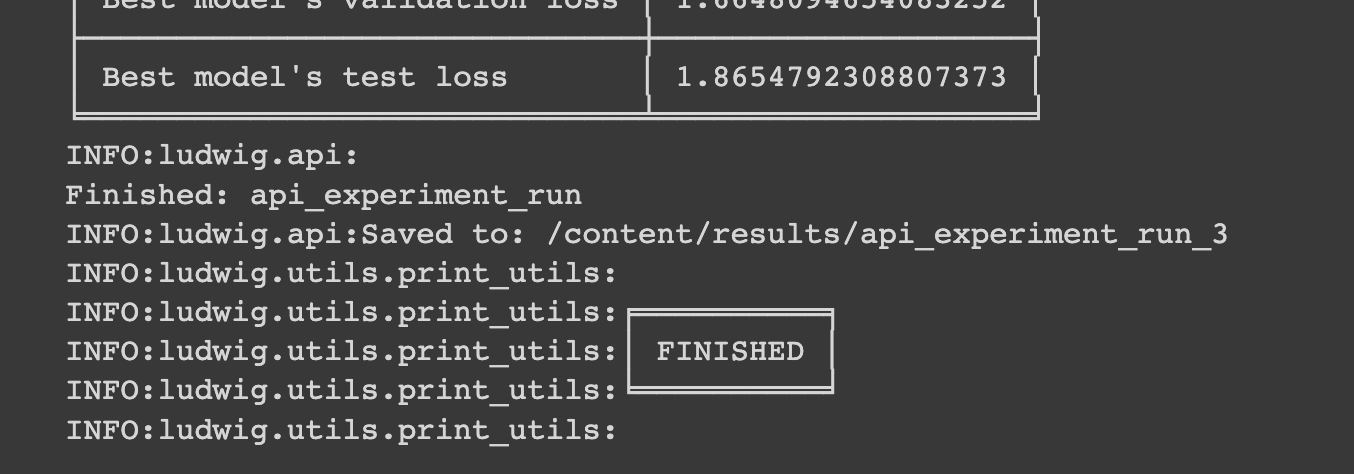

In [ ]:
!ludwig upload hf_hub --repo_id "alexsherstinsky/mistralai-7B-v01-based-finetuned-using-ludwig-with-samsum-A100-sharded-8bit-merged" --model_path /content/results/api_experiment_run


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) Y
Token is valid (permission: write).
Cannot authenticate through git-c

In [ ]:
samsum_fine_tuned_model_name: str = "alexsherstinsky/mistralai-7B-v01-based-finetuned-using-ludwig-with-samsum-A100-sharded-8bit-merged"

In [ ]:
gc.collect()

42

Load the finetuned LoRA layers for Mistral 7B LLM (adapter weights for SAMSum dataset).

In [ ]:
print(f'\n[LOADING_MODEL] FINE_TUNED_AND_MERGED:\n{samsum_fine_tuned_model_name}')
samsum_tokenizer: LlamaTokenizerFast = AutoTokenizer.from_pretrained(pretrained_model_name_or_path=samsum_fine_tuned_model_name, trust_remote_code=True, padding_side='left')
bnb_config_samsum_fine_tuned_model: BitsAndBytesConfig = BitsAndBytesConfig(
  load_in_8bit=True,
)
samsum_model: MistralForCausalLM = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=samsum_fine_tuned_model_name, torch_dtype=torch.float16, trust_remote_code=True, device_map="auto", quantization_config=bnb_config_samsum_fine_tuned_model, low_cpu_mem_usage=True)


[LOADING_MODEL] FINE_TUNED_AND_MERGED:
alexsherstinsky/mistralai-7B-v01-based-finetuned-using-ludwig-with-samsum-A100-sharded-8bit-merged


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
gc.collect()

1777

Run inference on finetuned Mistral 7B LLM for SAMSum dataset to verify quality.

In [ ]:
samsum_sequences_generator: TextGenerationPipeline = transformers.pipeline(
    task="text-generation",
    tokenizer=samsum_tokenizer,
    model=samsum_model,
    torch_dtype=torch.float16,
    device_map="auto",
)

In [ ]:
samsum_sequences: list[dict] | list[list[dict]] = samsum_sequences_generator(
    text_inputs=samsum_test_prompt,
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=samsum_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
samsum_sequence: dict = samsum_sequences[0]

In [ ]:
print(f'\n[GENERATED_TEXT] FINE_TUNED_MODEL_PREDICTION:\n{samsum_sequence["generated_text"]} ; TYPE: {str(type(samsum_sequence["generated_text"]))}')


[GENERATED_TEXT] FINE_TUNED_MODEL_PREDICTION:

Summarize this dialog:

### Dialogue: 
A: Hi Tom, are you busy tomorrow’s afternoon?
B: I’m pretty sure I am. What’s up?
A: Can you go with me to the animal shelter?.
B: What do you want to do?
A: I want to get a puppy for my son.
B: That will make him so happy.
A: Yeah, we’ve discussed it many times. I think he’s ready now.
B: That’s good. Raising a dog is a tough issue. Like having a baby ;-)
A: I'll get him one of those little dogs.
B: One that won't grow up too big;-)
A: And eat too much;-))
B: Do you know which one he would like?
A: Oh, yes, I took him there last Monday. He showed me one that he really liked.
B: I bet you had to drag him away.
A: He wanted to take it home right away ;-).
B: I wonder what he'll name it.
A: He said he’d name it after his dead hamster – Lemmy  - he's  a great Motorhead fan :-)))


### Synopsis:
A wants to get a puppy for his son from the animal shelter. B will go with him. ; TYPE: <class 'str'>


In [ ]:
gc.collect()

21

Run inference on finetuned Mistral 7B LLM for SAMSum dataset over the evaluation dataset.

In [ ]:
df_samsum_evaluation: pd.DataFrame = df_evaluation.copy()

In [ ]:
df_samsum_evaluation["prompt"] = df_samsum_evaluation["dialogue"].apply(lambda x: samsum_prompt_template.format(**{"dialogue": x}))

In [ ]:
samsum_sequences: list[dict] | list[list[dict]] = samsum_sequences_generator(
    text_inputs=df_samsum_evaluation["prompt"].to_list(),
    do_sample=True,
    top_k=50,
    num_return_sequences=1,
    eos_token_id=samsum_tokenizer.eos_token_id,
    max_length=512,
    return_text=True,
)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1268: UserWarning: Input length of input_ids is 571, but `max_length` is set to 512. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
print(f'\n[FINE_TUNED_MODEL_EVALUATION_BEGIN]')
idx: int = 0
print(f'\n[=============EXAMPLE_{idx}_BEGIN=============]')
for dialogue, synopsis in zip(df_samsum_evaluation["dialogue"].to_list(), samsum_sequences):
  print(f'\n[FINE_TUNED_MODEL_EVALUATION] GENERATED_SUMMARY:\n{synopsis[0]["generated_text"]}')
  print(f'\n[=============EXAMPLE_{idx}_END=============]')
  idx += 1

print(f'\n[FINE_TUNED_MODEL_EVALUATION_END]')


[FINE_TUNED_MODEL_EVALUATION_BEGIN]

[=============EXAMPLE_0_BEGIN=============]

[FINE_TUNED_MODEL_EVALUATION] GENERATED_SUMMARY:

Summarize this dialog:

### Dialogue: Adriana: Sorry, I guess I can't make it. I'm feeling sick again.
Adriana: I planned so many things for today...
Adriana: Hate it.
Elisa: What a pity...
Elisa: Next time!
Elisa: Hope you'll get better soon!
Adriana: Hope so too.
Adriana: How was at the pool?
Elisa: The best ❤️
Elisa: 1 hour of swimming and 1 hour of sauna
Elisa: Love it!
Adriana:❤️
Adriana: I'm such a bad swimmer that you couldn't stand me xD
Elisa: Ahahaha
Elisa: There was such a girl today, soooo annoying 😂
Adriana: Just like me 😂😂😂

### Synopsis:

Adriana can't make it today because she's sick. She was looking forward to it. Elisa enjoyed at the pool today.

[=============EXAMPLE_0_END=============]

[FINE_TUNED_MODEL_EVALUATION] GENERATED_SUMMARY:

Summarize this dialog:

### Dialogue: Claire: Have you seen the news?
Greg: No. What’s happened?
Clai